In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## OUTLIER DETECTION ON PLAYERS

IMPORT NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import OneClassSVM

FUNCTION TO LOAD THE DATASET

In [ ]:
def load_data(file_name, delimiter=','):
    return pd.read_csv(file_name, delimiter=delimiter)

FUNCTION TO CALCULATE EFFICIENCY RATING

In [ ]:
def calculate_eff_rating(data):
    EFF_Rating = (data['Points'] + data['Rebounds'] + data['Assists']) / data['Games Played']
    return EFF_Rating

FUNCTION TO DISPLAY A SAMPLE OF THE OUTLIERS

In [ ]:
def display_outliers(dataset):
    outliers = dataset[dataset['Outlier'] == 0]
    total_players = len(dataset)
    total_outliers = len(outliers)

    print(f"Total Players: {total_players}")
    print(f"Total Outstanding Players (Outliers): {total_outliers}")
    print("\nSample of Outstanding Players (Outliers - First 5 and Last 5 Values):\n")

    # Show first 5 and last 5 outliers
    if total_outliers > 0:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.colheader_justify', 'center'):
            print(pd.concat([outliers.head(5), outliers.tail(5)]).to_string(index=False))
    else:
        print("No outliers detected.")


FUNCTION TO PLOT CONFUSION MATRIX

In [ ]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',xticklabels=['Outlier (-1)', 'Inlier (1)'],yticklabels=['Outlier (-1)', 'Inlier (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

FUNCTION TO VISUALIZE OUTLIERS FOR EACH CLASSIFIER

In [ ]:
def plot_outliers_for_classifier(classifier_name, X, y_pred):
    plt.figure(figsize=(10, 6))
    colors = ['red' if y == -1 else 'blue' for y in y_pred]
    plt.scatter(X[:, 0], X[:, 4], c=y_pred, cmap='coolwarm_r')
    plt.title(f'Outlier Detection in Player Performance - {classifier_name}')
    plt.xlabel('Minutes')
    plt.ylabel('EFF Rating')
    plt.colorbar(label='Outlier (-1) / Inlier (1)')
    plt.show()

FUNCTION TO VISUALIZE OUTLIER DETECTION RESULTS

In [ ]:
def plot_outlier_detection(dataset):
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset['Minutes'], dataset['EFF Rating'], c=dataset['Outlier'], cmap='coolwarm', alpha=0.6)
    plt.title('Outlier Detection in Player Performance')
    plt.xlabel('Minutes')
    plt.ylabel('EFF Rating')
    plt.colorbar(label='Outlier (-1) / Inlier (1)')
    plt.axhline(0, color='grey', lw=1, ls='--')
    plt.axvline(0, color='grey', lw=1, ls='--')
    plt.show()

FUNCTION FOR OUTLIER DETECTION AND CLASSIFICATION

In [ ]:
def find_outstanding_players(stats_file, career_totals_file, delimiter=','):
    player_stats = load_data(stats_file, delimiter)
    player_stats.columns = ['ilkid', 'Year', 'First Name', 'Last Name', 'Team', 'League', 'Games Played', 'Minutes',
                            'Points', 'Offensive Rebounds', 'Defensive Rebounds', 'Rebounds', 'Assists', 'Steals',
                            'Blocks', 'Turnovers', 'Personal Fouls', 'Field Goals Attempted', 'Field Goals Made',
                            'Free Throws Attempted', 'Free Throws Made', 'Three-Point Attempts', 'Three-Pointers Made']

    player_stats = player_stats[player_stats['Minutes'] > 0]

    # Calculate EFF Rating
    player_stats['EFF Rating'] = calculate_eff_rating(player_stats)

    # Select relevant features
    features = player_stats[['EFF Rating', 'Points', 'Rebounds', 'Assists', 'Minutes']]

    # Scale the data
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Initialize Isolation Forest for outlier detection
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    player_stats['Outlier'] = iso_forest.fit_predict(features_scaled)

    # Change the labels: -1 to 0 (Outlier) and 1 to 1 (Inlier)
    player_stats['Outlier'] = player_stats['Outlier'].map({-1: 0, 1: 1})

    display_outliers(player_stats)
    plot_outlier_detection(player_stats)

    # Split data for classification
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, player_stats['Outlier'], test_size=0.3, random_state=42)

    # Initialize classifiers
    classifiers = {
        'Random Forest Classifier': RandomForestClassifier(n_estimators=100),
        # Add other classifiers here as needed
    }

    # Train and evaluate classifiers
    classifiers = {
        'Random Forest Classifier': RandomForestClassifier(n_estimators=100),
        'K-Nearest Neighbors Classifier': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
        'Gradient Boosting Classifier': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
    }

    # Train and evaluate classifiers
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(f"\n{clf_name} Report:")
        report = classification_report(y_test, y_pred,  target_names=['Outlier (0)', 'Inlier (1)'])
        print(report)

        plot_confusion_matrix(y_test, y_pred, clf_name)

        plot_outliers_for_classifier(clf_name, X_test, y_pred)

CALL FUNCTION FOR OUTLIER DETECTION

Total Players: 18084
Total Outstanding Players (Outliers): 905

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid    Year First Name Last Name  Team League  Games Played  Minutes  Points  Offensive Rebounds  Defensive Rebounds  Rebounds  Assists  Steals  Blocks  Turnovers  Personal Fouls  Field Goals Attempted  Field Goals Made  Free Throws Attempted  Free Throws Made  Three-Point Attempts  Three-Pointers Made  EFF Rating  Outlier
MIKANGE01  1951   George        Mikan MIE    N          64        2572     1523            0                   0             866     194        0       0       0.0          286                1414                 545                 555                  433                   0                    0           40.359375     0    
PHILLAN01  1951     Andy      Phillip PH1    N          66        2933      790            0                   0             434     539        0       0       0.0          218                 762           

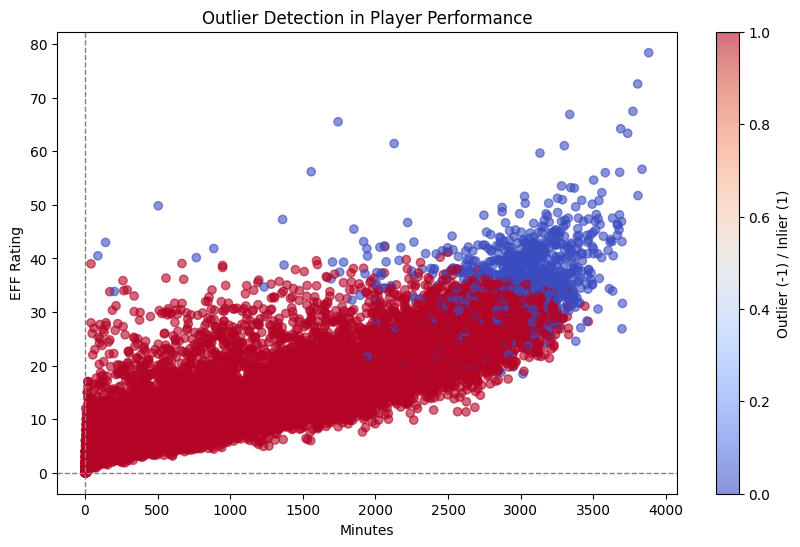


Random Forest Classifier Report:
              precision    recall  f1-score   support

 Outlier (0)       0.90      0.91      0.90       286
  Inlier (1)       0.99      0.99      0.99      5140

    accuracy                           0.99      5426
   macro avg       0.95      0.95      0.95      5426
weighted avg       0.99      0.99      0.99      5426



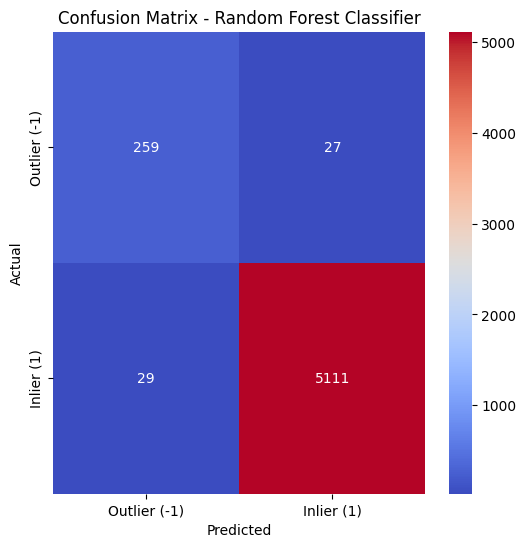

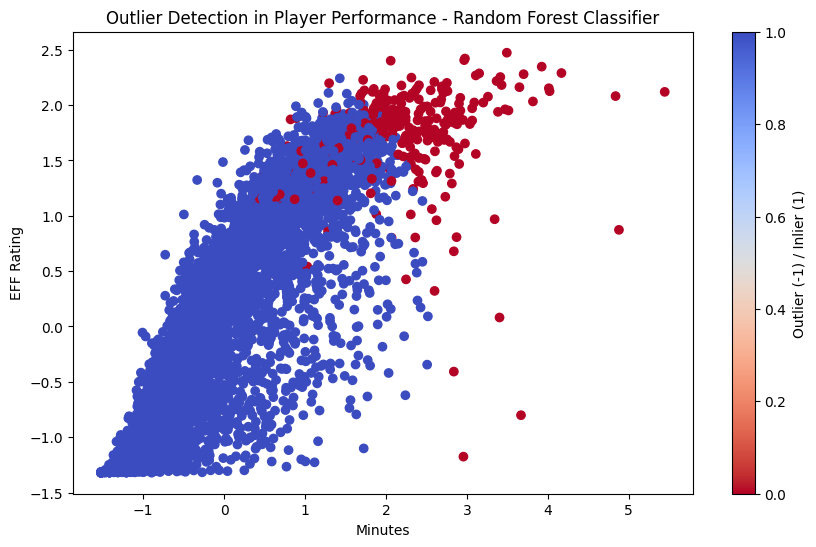


K-Nearest Neighbors Classifier Report:
              precision    recall  f1-score   support

 Outlier (0)       0.96      0.83      0.89       286
  Inlier (1)       0.99      1.00      0.99      5140

    accuracy                           0.99      5426
   macro avg       0.97      0.91      0.94      5426
weighted avg       0.99      0.99      0.99      5426



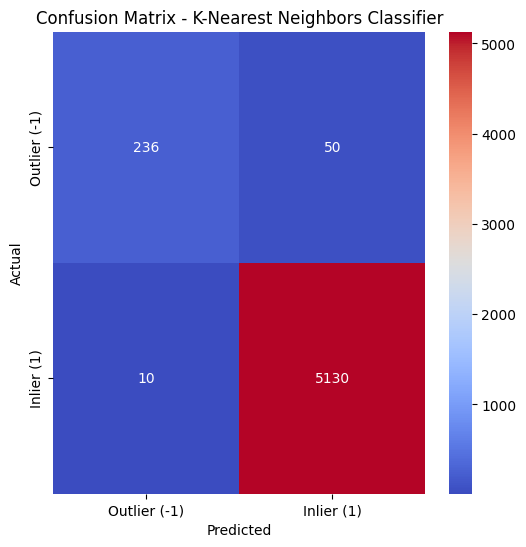

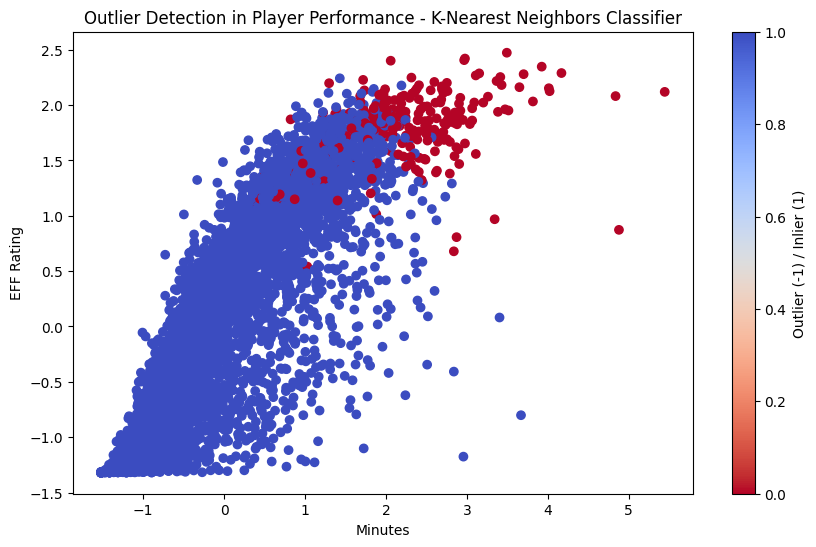


Decision Tree Classifier Report:
              precision    recall  f1-score   support

 Outlier (0)       0.89      0.88      0.89       286
  Inlier (1)       0.99      0.99      0.99      5140

    accuracy                           0.99      5426
   macro avg       0.94      0.94      0.94      5426
weighted avg       0.99      0.99      0.99      5426



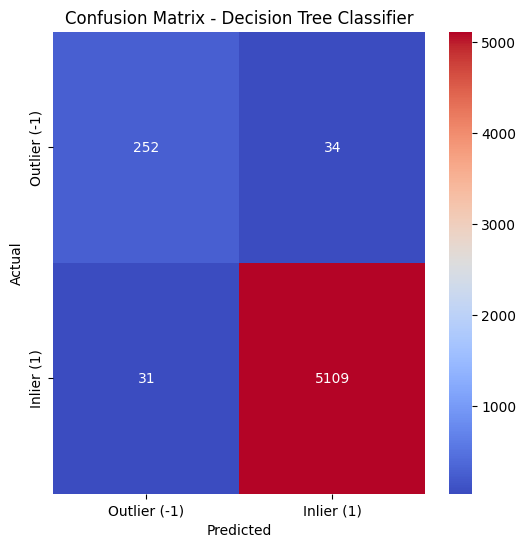

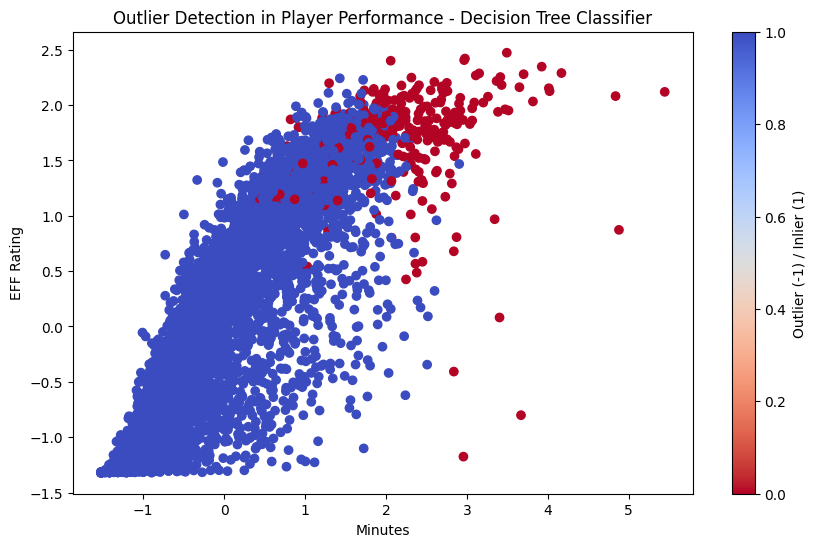


Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

 Outlier (0)       0.91      0.90      0.91       286
  Inlier (1)       0.99      1.00      0.99      5140

    accuracy                           0.99      5426
   macro avg       0.95      0.95      0.95      5426
weighted avg       0.99      0.99      0.99      5426



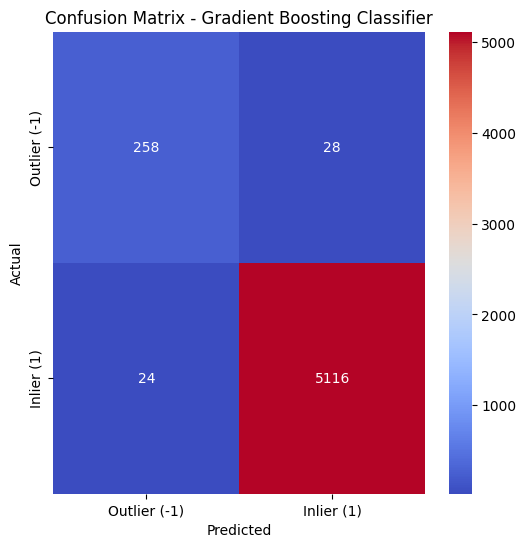

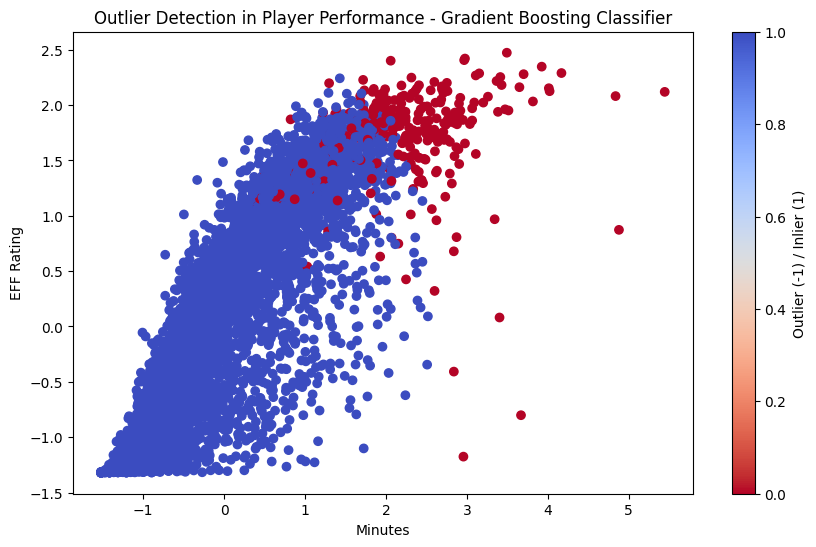

In [ ]:
find_outstanding_players('/content/player_regular_season.txt', '/content/player_regular_season_career.txt', delimiter=',')